# Mounting Goolge drive.

First add the data to your google drive using the following link:

https://drive.google.com/drive/folders/1I0MTQwn2HXquEiXdtntgRggqw6xJr47b?usp=sharing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing required packages

GPU and available memory check

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
Gen RAM Free: 59.2 GB  |     Proc size: 55.2 MB
GPU RAM Free: 11018MB | Used: 1MB | Util   0% | Total     11019MB


Transformers for general purpose NLP models

Unidecode for ASCII translation of Unicode text.

In [2]:
!pip3 install transformers
!pip3 install unidecode

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import join
import unidecode
import re
import logging
from tqdm.notebook import tnrange
import glob
import json

#For ploting results
import matplotlib.pyplot as plt

# DL Libraries
from transformers import BertModel, AdamW, BertTokenizer, BertConfig, RobertaTokenizer, RobertaModel
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("device: {} n_gpu: {}".format(device, n_gpu)) 

device: cuda n_gpu: 2


In [5]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
print(logger)

<Logger __main__ (INFO)>


#Data Processing

Function to tokenize input dataframe (Query, Sentence, Label) and return tensorDatset with corresponding input_id, attention_masks and labels as a PyTorch dataloader. 

In [6]:
def create_dataloader(tokenizer, df):
    input_ids= list()
    attention_masks= list()

    print("Shape: {}".format(df.shape))

    special_sentences_1 = [sentence for i, sentence in enumerate(df.question)]
    special_sentences_2 = [" [SEP] " + str(sentence) for i, sentence in enumerate(df.sentence)]
    special_sentences = [i + j for i, j in zip(special_sentences_1, special_sentences_2)]

    for sentence in special_sentences:
      encoded_text = tokenizer.encode_plus(sentence, max_length=512, add_special_tokens=True, return_token_type_ids=False, 
                                       padding='max_length', return_attention_mask=True, truncation=True)
      input_ids.append(encoded_text['input_ids'])
      attention_masks.append(encoded_text['attention_mask'])

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)
    gold_labels = torch.tensor(df.sia_score.tolist()).to(device)
  
    data = TensorDataset(inputs, masks, gold_labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=4)

    return dataloader

To load the dataset from google drive.

**!!! Please change the directory accordingly !!!**

Performing the train-test split after shuffling the dataset.

In [7]:
# load_data= '/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset'
load_data = '/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/output_df'

data_df= pd.read_csv(join(load_data,'result_exact_ans_0_5000.csv'))
data_df.head()
data_df= shuffle(data_df)

train_df, test_df= train_test_split(data_df, test_size=0.2)


In [8]:
data_df.head()
print("length",len(data_df))

length 49519


Loading pretrained 'roberta-base' tokenizer and creating dataloader for train & test dataframes.

In [9]:
#Dataloaders
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataloader= create_dataloader(tokenizer, train_df)
test_dataloader= create_dataloader(tokenizer, test_df)

Shape: (39615, 4)
Shape: (9904, 4)


# Model

Model: 'roberta-base' with a Linear layer on top to generate SIA scores.

In [10]:
#Class for Regression
class Regressor(nn.Module):

  def __init__(self):
    super(Regressor, self).__init__()
    self.bert = RobertaModel.from_pretrained('roberta-base')
    self.out = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    output, pooler_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    score= self.out(pooler_out)
    return score
    

Model Initialization with:

* 10 epochs

* 'AdamW' optimizer

* Mean Squared Error (MSE) Loss function

In [11]:
#Model Intialization

epochs=10

#Load Model
model= Regressor()
model.to(device)

# Prepare optimizer
optimizer = AdamW(model.parameters(),lr=2e-5)

#Loss Function
mse_loss= nn.MSELoss().to(device)

#Training and Evaluation

Creating output directory:

model path: '/content/drive/My Drive/project_nlp/sia_experiment/model1'

result path: '/content/drive/My Drive/project_nlp/sia_experiment/results1'

In [12]:
output_dir= '/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/model'
output_result= '/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

if not os.path.exists(output_result):
  os.makedirs(output_result)

Model training followed by model evaluation

In [13]:
for iteration in tnrange(epochs, desc='Epochs'):
  model.train()
  logger.info("Running for iteration: {}".format(iteration+1))

  training_loss, training_steps=0,0
  true_labels, predicted_labels= list(), list()
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    ip_ids, masks, gold_labels= batch
    score = model(ip_ids, attention_mask=masks)
    score = score.squeeze(1)
    loss= mse_loss(score, gold_labels.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    training_loss+=loss.item()
    training_steps+=1
    if (step+1)%10000 == 0:
      print(step+1)

    true_labels.extend(gold_labels.cpu().numpy())
    predicted_labels.extend(score.detach().cpu().numpy())
  
  training_loss_for_epoch= training_loss/training_steps
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  accuracy=r2_score(true_labels, predicted_labels)
  result = {'loss': training_loss_for_epoch, 'PCC': pcc[0], 'RMSE':rmse, 'R2_score':accuracy}
  print(result)

  model_to_save = model.bert.module if hasattr(model.bert, 'module') else model.bert
  model_to_save.save_pretrained(output_dir)

  torch.save(model.out.state_dict(), join(output_dir, 'model_state.bin'))

  #Testing
  print("Running evaluation for epoch: {}".format(iteration+1))

  true_labels, predicted_labels= list(), list()
  model.eval()
  with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)
      ip_ids, masks, gold_labels= batch
      score = model(ip_ids, attention_mask=masks)
      score = score.squeeze(1)

      true_labels.extend(gold_labels.cpu().numpy())
      predicted_labels.extend(score.detach().cpu().numpy())
  
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  accuracy=r2_score(true_labels, predicted_labels)
  test_report= {'PCC': pcc[0], 'RMSE':str(rmse), 'R2_score':str(accuracy)}
  print(test_report)

  with open(join(output_result, 'result_'+str(iteration+1)+'.json'), 'w') as fp:
    json.dump(test_report, fp)

11/26/2020 12:18:02 - INFO - __main__ -   Running for iteration: 1


{'loss': 0.3889545313036435, 'PCC': 0.8298438385509141, 'RMSE': 0.6236691, 'R2_score': 0.6882166489890609}
Running evaluation for epoch: 1


11/26/2020 12:48:10 - INFO - __main__ -   Running for iteration: 2


{'PCC': 0.9016309101879774, 'RMSE': '0.49835458', 'R2_score': '0.8025171546105003'}
{'loss': 0.24636793478686875, 'PCC': 0.8958576792481245, 'RMSE': 0.4963604, 'R2_score': 0.8025128880323512}
Running evaluation for epoch: 2


11/26/2020 13:18:18 - INFO - __main__ -   Running for iteration: 3


{'PCC': 0.9082992037802233, 'RMSE': '0.4986085', 'R2_score': '0.8023158772283197'}
{'loss': 0.21142225470271298, 'PCC': 0.9113472718717065, 'RMSE': 0.45980796, 'R2_score': 0.830528176750083}
Running evaluation for epoch: 3


11/26/2020 13:48:33 - INFO - __main__ -   Running for iteration: 4


{'PCC': 0.9225527918919763, 'RMSE': '0.43570897', 'R2_score': '0.8490457164086676'}
{'loss': 0.18935603993387262, 'PCC': 0.9209956558550079, 'RMSE': 0.43515494, 'R2_score': 0.8482137756243184}
Running evaluation for epoch: 4


11/26/2020 14:18:41 - INFO - __main__ -   Running for iteration: 5


{'PCC': 0.9167364509608176, 'RMSE': '0.4720114', 'R2_score': '0.8228433542136016'}
{'loss': 0.16408932274935772, 'PCC': 0.931921166103721, 'RMSE': 0.40508252, 'R2_score': 0.8684679611717238}
Running evaluation for epoch: 5


11/26/2020 14:48:54 - INFO - __main__ -   Running for iteration: 6


{'PCC': 0.9257493697866076, 'RMSE': '0.4352826', 'R2_score': '0.8493410098562046'}
{'loss': 0.15918844906906068, 'PCC': 0.9340271774337875, 'RMSE': 0.398988, 'R2_score': 0.8723960064089205}
Running evaluation for epoch: 6


11/26/2020 15:19:08 - INFO - __main__ -   Running for iteration: 7


{'PCC': 0.9223223786525179, 'RMSE': '0.43848526', 'R2_score': '0.8471158464847637'}
{'loss': 0.14251308864307796, 'PCC': 0.9411533708537055, 'RMSE': 0.37751237, 'R2_score': 0.8857629732298671}
Running evaluation for epoch: 7


11/26/2020 15:49:18 - INFO - __main__ -   Running for iteration: 8


{'PCC': 0.923060956151966, 'RMSE': '0.44209263', 'R2_score': '0.8445899692074882'}
{'loss': 0.1390465658224385, 'PCC': 0.9426278737137489, 'RMSE': 0.37289307, 'R2_score': 0.8885415069073913}
Running evaluation for epoch: 8


11/26/2020 16:19:32 - INFO - __main__ -   Running for iteration: 9


{'PCC': 0.9093623971611708, 'RMSE': '0.48283246', 'R2_score': '0.8146274701095978'}
{'loss': 0.12822097885187284, 'PCC': 0.9472198816243766, 'RMSE': 0.35807908, 'R2_score': 0.897221472778468}
Running evaluation for epoch: 9


11/26/2020 16:49:47 - INFO - __main__ -   Running for iteration: 10


{'PCC': 0.9241115098680814, 'RMSE': '0.44150466', 'R2_score': '0.8450030972277631'}
{'loss': 0.1539306600475125, 'PCC': 0.93627719819775, 'RMSE': 0.3923448, 'R2_score': 0.8766098793594983}
Running evaluation for epoch: 10
{'PCC': 0.9265686239584561, 'RMSE': '0.4241227', 'R2_score': '0.856967239017703'}



# Visualizing the results

In [15]:
filepaths= glob.glob(join(output_result,'*.json'))

pcc, rmse= list(), list()

for path in filepaths:
  print(path)
  f = open(path,'r')
  data = json.load(f)
  pcc.append(data['PCC'])  
  rmse.append(float(data['RMSE']))

/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_7.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_10.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_5.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_1.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_6.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_4.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_2.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_9.json
/home/tharun/Downloads/Gouthami/NLP_Project/Training_Data/Submission/roberta_training/output/result_3.json
/home/tharun/Downloads/Gouthami/NLP_

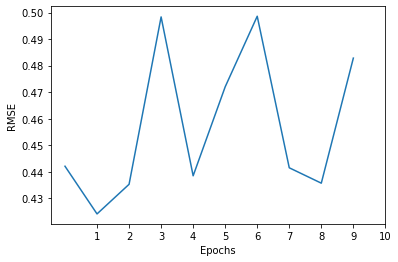

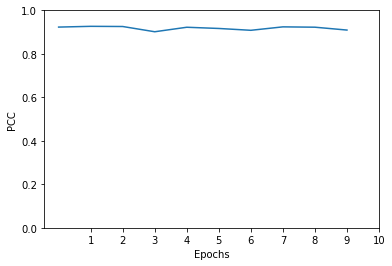

In [16]:
#plot rmse
plt.plot(rmse)
plt.ylabel('RMSE')
plt.xticks(range(1, 11))
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'rmse.png'))
plt.show()

#plot
plt.plot(pcc)
plt.ylabel('PCC')
plt.xticks(range(1, 11))
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'pcc.png'))
plt.show() 